In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_SSL로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LG_ES_SSL.git
%cd /content/2025_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

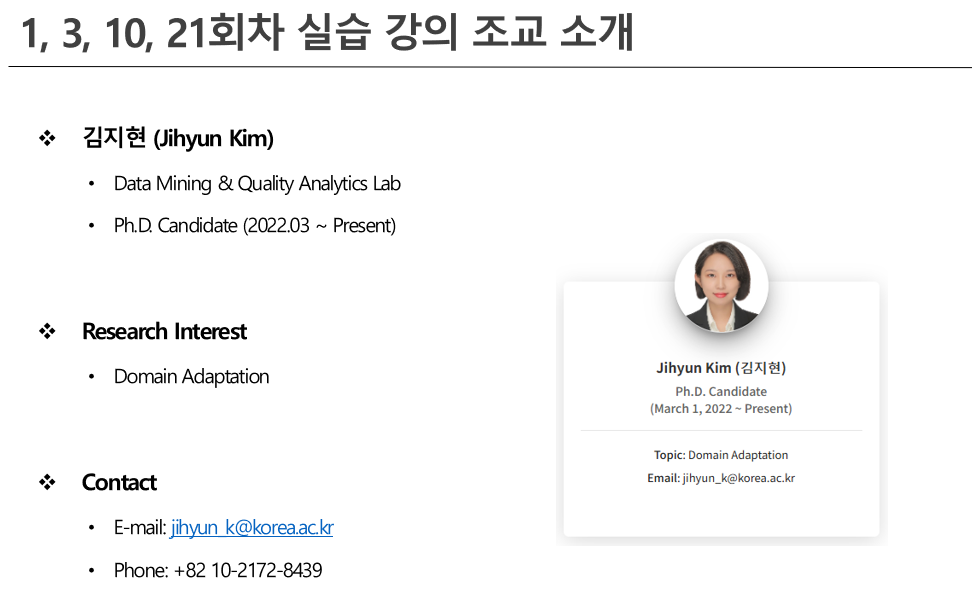

In [2]:
Image('./images/img0.png')

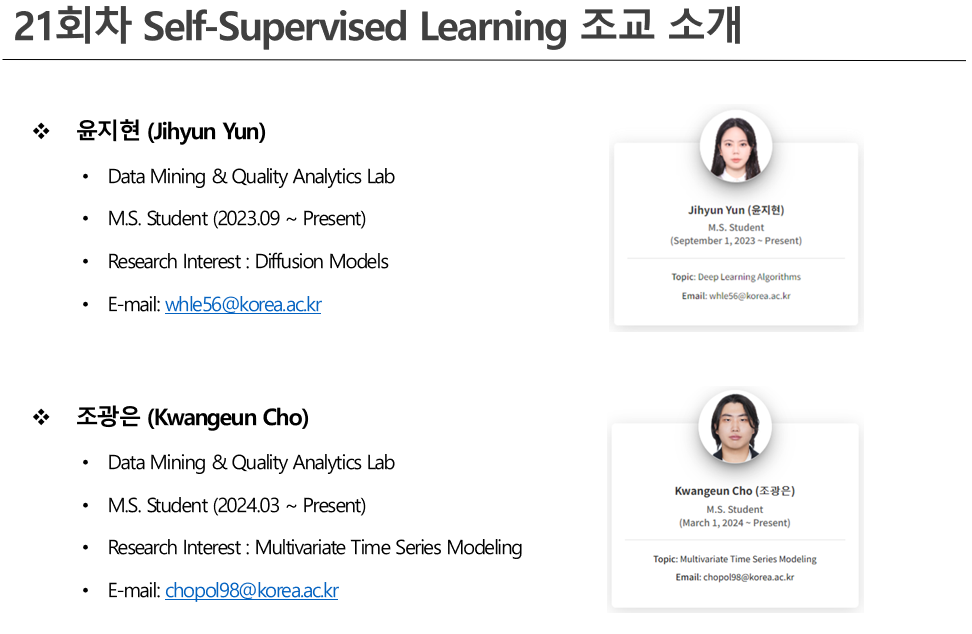

In [2]:
Image('./images/assist.png')

------

## Task: Self-supervised Learning - Non Contrastive Learning

#### 질문. Negative samples은 왜 필요한가?
- 특정 이미지에 대한 표현학습을 수행할 때, 다른 샘플과의 비교를 통해서 학습이 이루어지는 이유?
- Negative samples 없이 학습을 진행하면, 모델이 데이터 간의 차이를 배우지 못할 수 있기 때문!
- 이에 따라 모든 입력에 대해 동일한 벡터를 출력하는 등, 의미 없는 정보 값만으로도 positive pair를 가깝게 만드는 현상 (**Collapse 문제**)이 발생할 수 있음  


#### 단점:
- 큰 Batch size 요구 -> Computational Cost 증가

### **B**ootstrap **Y**our **O**wn **L**atent (BYOL)

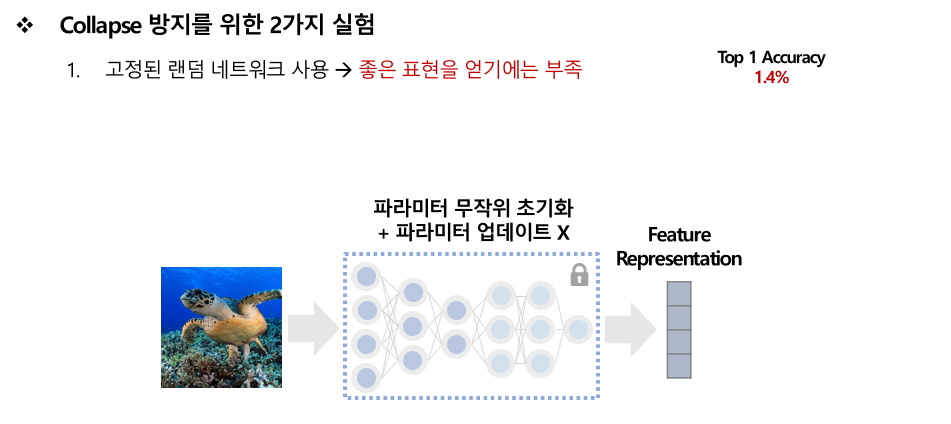

In [3]:
Image('./images/byol_insight1.PNG')

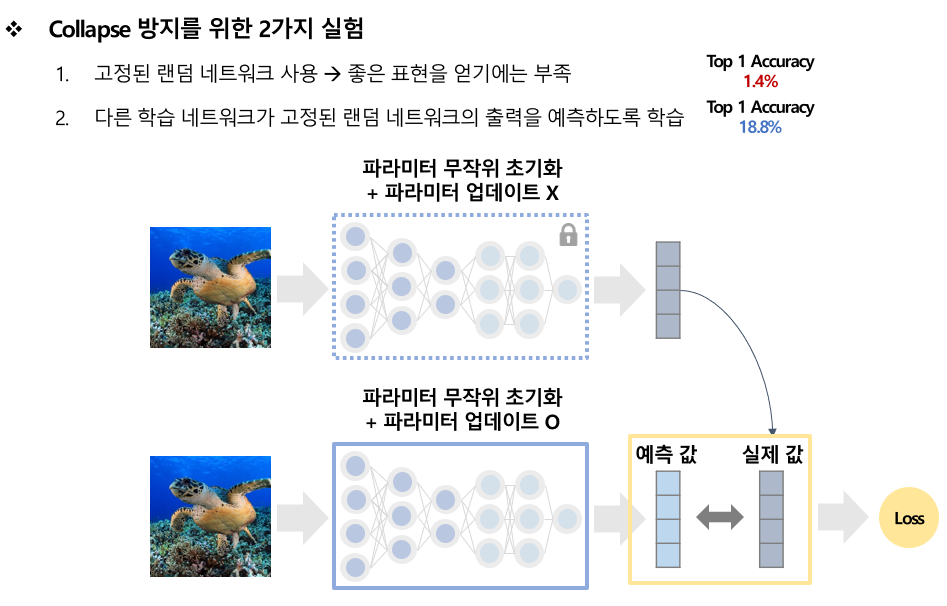

In [4]:
Image('./images/byol_insight2.PNG')

#### Self-prediction
- 나의 상태를 예측해보자!
- '예측 작업'은 모델이 입력 데이터에서 중요한 패턴/정보를 추출하도록 강제
    - 즉, 모델이 데이터의 내재된 구조적 특성을 포착하도록 하는 것임

## 1. 필요 라이브러리 호출

In [3]:
import os, random, time, copy
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. Dataset 및 Dataloader 정의

### 실습 데이터셋: CIFAR10
- 32x32의 RGB 이미지로 구성된 데이터셋
- 10개의 class를 분류하는 image classification task에 주로 활용

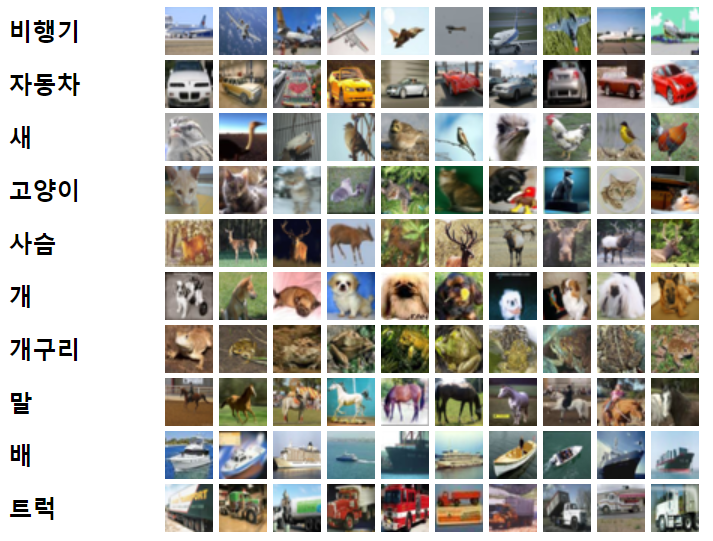

In [ ]:
Image('images/7-CIFAR101.PNG')

  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 별도로 구분하지 않음)

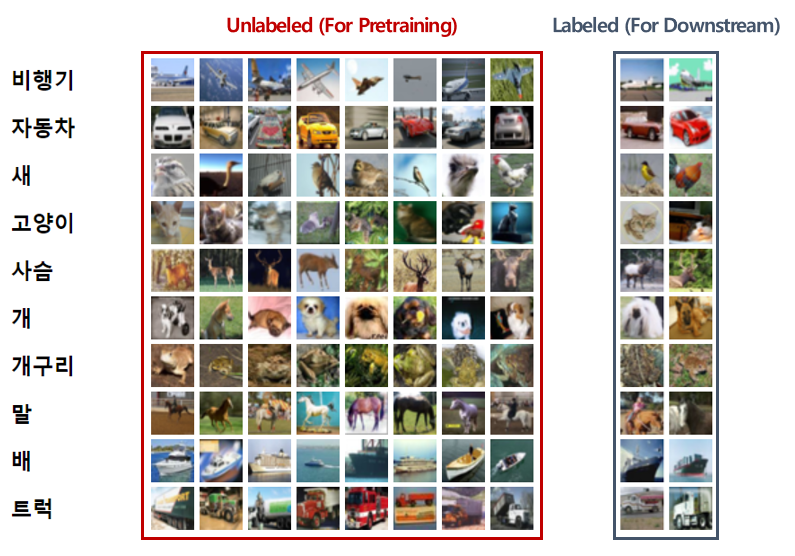

In [ ]:
Image('images/7-CIFAR102.PNG')

In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, configs:dict, aug_generator:object):
        self.configs = configs
        self.data_dir = configs['data_dir']
        self.aug_generator = aug_generator

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(self.data_dir, exist_ok=True)

    """For SimCLR : SimCLR 사전학습 시 사용되는 데이터셋"""
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=self.aug_generator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    """For Downstream task : Downstream 지도학습에 사용되는 데이터"""
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), 
                                               test_size=0.2,
                                               random_state=self.configs['seed'])

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        
    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(s:float=.5):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper! (BYOL은 SimCLR과 동일한 데이터 증강기법을 적용)
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        # 이미지 데이터 내의 값을 정규화
        ## gradient 역전파 과정에서 중요 (큰 값은 activation function 출력 값을 포화 영역에 다다르게 함 -> 미분 값이 작아짐 -> 기울기 소실)
        ## 작은 범위의 값으로 학습 안전성 확보
        ## 더불어 RGB 채널 중 특정 채널에 가중이 크게 치우치는 것을 방지 (스케일 차이로 인하여) (모든 색상 정보를 균등하게 고려)

        # normalized = (original - mean) / std.   # Standardization
        # CIFAR-10에 특화된 normalize!!
        normalize = transforms.Normalize( 
            mean=(0.4914, 0.4822, 0.4465),  # R, G, B 채널 평균 값
            std=(0.2023, 0.1994, 0.2010)    # R, G, B 채널의 표준편차
        )

        # s is the strength of color distortion (0.5 for CIFAR10 by default)
        color_jitter = transforms.ColorJitter(0.8*s, 
                                              0.8*s,
                                              0.8*s,
                                              0.2*s)
        
        # See Section B.9 of SimCLR: https://arxiv.org/abs/2002.05709
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms

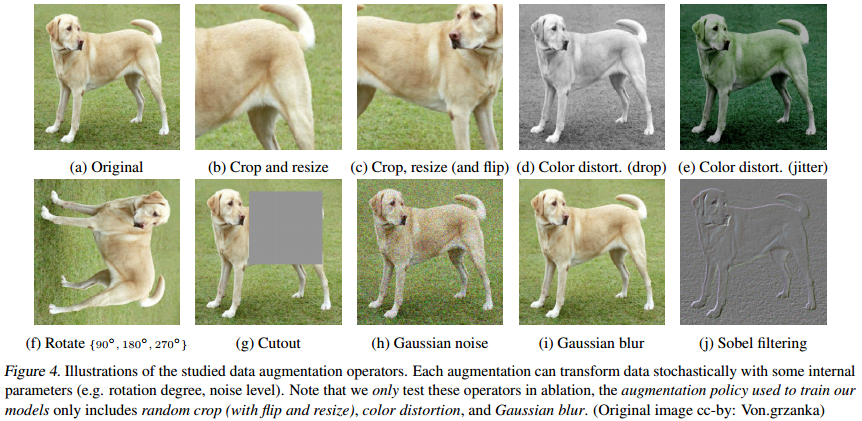

In [ ]:
Image('images/SimCLR_aug.PNG')

In [5]:
"""사전에 정의한 transform 방식을 기반으로 증강된 이미지를 반환해주는 class"""
class aug_generator(object):
    """
    Take 2 random crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # aug_generator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

Files already downloaded and verified


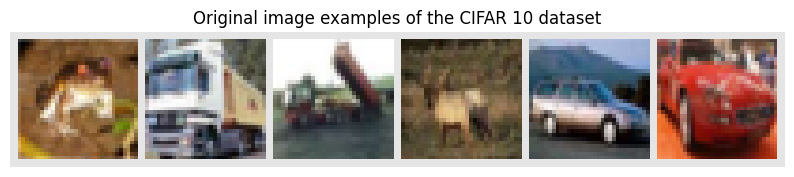

Files already downloaded and verified


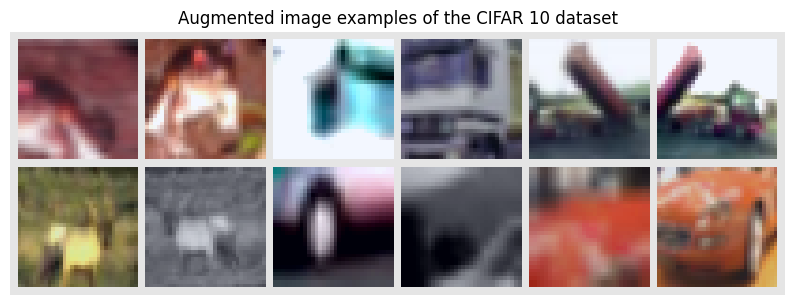

In [6]:
""" 실제 CIFAR10이미지와 증강된 CIFAR10이미지 비교 """
##### Original CIFAR10 이미지 #####
data_dir = './data/'

### 데이터셋 불러오기
Cifar10_original = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([Cifar10_original[idx][0] for idx in range(6)], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

### 시각화
plt.figure(figsize=(10, 5))
plt.title('Original image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


##### 증강된 CIFAR10 이미지 #####
### 데이터셋 불러오기
data_configs = {'data_dir':data_dir}
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()
imgs = torch.stack([img for idx in range(6) for img in Cifar10_aug_dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

### 시각화
plt.figure(figsize=(10, 5))
plt.title('Augmented image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

--------

## 3. BYOL 모델 정의

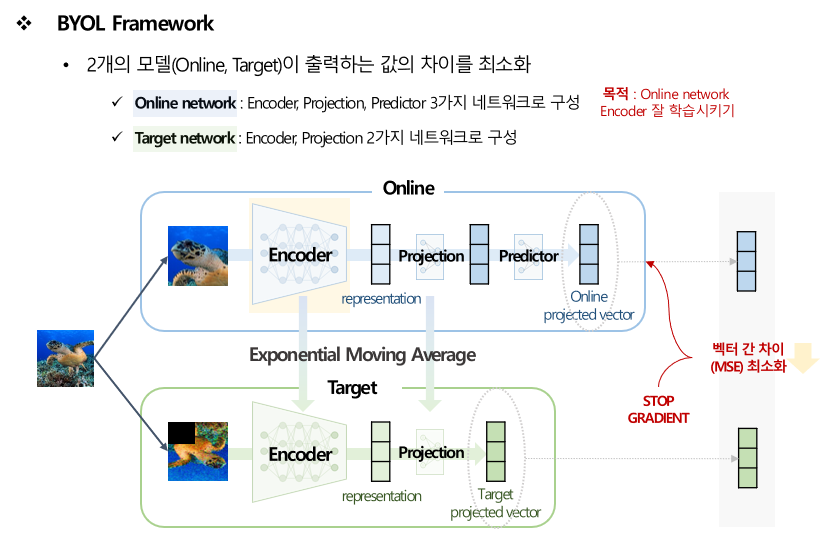

In [13]:
Image('images/byol_framework.PNG')

In [7]:
class BYOL(nn.Module):
    def __init__(self, configs):
        super(BYOL, self).__init__()
        self.configs = configs
        self.device = configs['device']

        self.backbone = configs['backbone']
        self.hidden_dim = configs['hidden_dim']
        self.projection_dim = configs['projection_dim']

        self.momentum = configs['momentum']

        ## Base encoder 선정
        # load model from torchvision.models without pretrained weights.
        resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   
            'resnet50': models.resnet50(pretrained=False)
        }
        self.encoder = resnet_dict[self.backbone]

        # Customize for CIFAR10. Replace conv 7z7 with conv 3x3, and remove first max pooling
        self.encoder.conv1 = nn.Conv2d(in_channels=3,
                                       out_channels=64, 
                                       kernel_size=3, 
                                       stride=1, 
                                       padding=1, 
                                       bias=False)
        
        self.encoder.maxpool = nn.Identity()  # 입력과 동일한 tensor를 출력으로 내보내주는 layer

        """get feature dim from in_features in fc-layer for resnet18 in torchvision"""
        feature_dim = self.encoder.fc.in_features  # resnet18.fc.in_features=256
        self.encoder.fc = nn.Identity()  # remove final fully connected layer

        self.online_network = copy.deepcopy(self.encoder).to(self.device)
        self.target_network = copy.deepcopy(self.encoder).to(self.device)

        # Add MLP projection
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_dim), 
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_dim, self.projection_dim)
        )

        # Add MLP predictor
        self.predictor = nn.Sequential(
            nn.Linear(self.projection_dim, self.projection_dim), 
            nn.BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim)
        )

    def forward(self, img1, img2):
        loss = self.byol_loss(img1, img2)

        return loss
    
    def byol_loss(self, 
                  batch_view_1: torch.FloatTensor, 
                  batch_view_2: torch.FloatTensor):
        
        ### Online Network에 증강된 2개 이미지 통과
        H1_online = self.online_network(batch_view_1)
        Z1_online = self.projector(H1_online)

        H2_online = self.online_network(batch_view_2)
        Z2_online = self.projector(H2_online)

        pred_online_1 = self.predictor(Z1_online)
        pred_online_2 = self.predictor(Z2_online)

        ### Online Network에 증강된 2개 이미지 통과 (Stop Gradient)
        with torch.no_grad():
            Z2_target = self.projector(self.target_network(batch_view_1))
            Z1_target = self.projector(self.target_network(batch_view_2))

        ### 각 증강된 이미지 별로 Loss를 한 번씩 계산
        loss = self.get_mse_loss(pred_online_1, Z1_target)
        loss += self.get_mse_loss(pred_online_2, Z2_target)

        return loss.mean()
    
    @staticmethod
    def get_mse_loss(x: torch.FloatTensor, y:torch.FloatTensor):
        x = F.normalize(x, dim=1)
        y = F.normalize(y, dim=1)

        # 유사도에 대한 MSE이기에, 유사도가 클수록 작은 패널티를 부과하기 위해 역수 적용
        return 2 - 2 * (x * y).sum(dim=-1)
    
    # target network를 Exponential Moving Average로 update하는 함수
    @torch.no_grad()
    def update_target_network(self):
        for param_q, param_k in zip(self.online_network.parameters(), self.target_network.parameters()):
            param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)

In [8]:
data_configs = {'data_dir':'./data/'}
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()

img_list, labels = next(iter(DataLoader(Cifar10_aug_dataset, batch_size=3)))  # labeels도 반환
img1, img2 = img_list[0], img_list[1]

model_configs = {'device':'cpu',
                 'backbone':'resnet18',
                 'hidden_dim': 512,
                 'projection_dim':128,
                 'momentum':0.996}
byol = BYOL(model_configs)

Files already downloaded and verified


online network

In [20]:
# 2개의 z vector (online network를 위함)
H1_online = byol.online_network(img1)
Z1_online = byol.projector(H1_online)

H2_online = byol.online_network(img2)
Z2_online = byol.projector(H2_online)

# online network는 predictor를 거침. 표현학습을 위한 추가적인 비대칭성 도입
pred_online_1 = byol.predictor(Z1_online)
pred_online_2 = byol.predictor(Z2_online)

target network

In [18]:
# 2개의 z vector (target network를 위함)
## target network는 gradient 계산을 하지 않음! (Online network의 파라미터를 기반으로 EMA 업데이트)
with torch.no_grad():
    H1_target = byol.target_network(img1)
    Z1_target = byol.projector(H1_target)

    H2_target = byol.target_network(img2)
    Z2_target = byol.projector(H2_target)

In [19]:
def get_mse_loss(x: torch.FloatTensor, y:torch.FloatTensor):
    x = F.normalize(x, dim=1)
    y = F.normalize(y, dim=1)

    # 2 - 2 * cosine similarity 형태의 loss를 계산합니다.
    # 유사도에 대한 MSE이기에, 유사도가 클수록 작은 패널티를 부과하기 위해 역수 적용
    return 2 - 2 * (x * y).sum(dim=-1)

$2 - 2 * cosine similarity$  
- 위 공식은 L2 거리의 제곱과 동일 (MSE): $||x - y||^2 = 2 - 2cos(θ)$
    - $L2 = \sqrt{((x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^2)}$
    - $MSE = (1/n) * (L2)^2$
- 유사도가 1에 가까울수록 (즉, 벡터가 유사할수록) 손실은 0에 가까워짐
- 유사도가 -1에 가까울수록 (즉, 벡터가 반대 방향일수록) 손실은 4에 가까워짐
- MSE를 직접 계산하는 것보다 빠르고, 정규화된 벡터를 사용하기 때문에 scale과 무관

In [23]:
loss_1 = get_mse_loss(pred_online_1, Z1_target)
loss_2 = get_mse_loss(pred_online_2, Z2_target)

loss = loss_1 + loss_2
loss.mean()

tensor(3.9699, grad_fn=<MeanBackward0>)

-------

## 4. 모델 학습

### Optimizer 정의

In [9]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = torch.optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=0.9, weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

### 모델 학습 추세 시각화 함수 정의

In [10]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['loss'])+1), y=epoch_history['loss'], label="Pretrain Loss")
    plt.title("Pretrain Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

### 사전학습 과정 함수화

In [11]:
def pretrain(device, model, pretrain_loader, optimizer):
    model.train()
    num_iterations = len(pretrain_loader)
    pretrain_history = {'loss': torch.zeros(num_iterations)}

    for i, (img, _) in enumerate(pretrain_loader):
        """사전학습 단계에서는 X 데이터만 batch로 받을 수 있음! (y는 없음)"""

        # 증강된 두 데이터 불러오기
        img_aug_1, img_aug_2 = img[0].to(device), img[1].to(device)

        # loss 계산!
        loss = model(img_aug_1, img_aug_2)

        """Online Network 학습"""
        loss.backward()
        optimizer.step()       # optimizer를 이용한 파라미터 업데이트
        optimizer.zero_grad()  # Optimizer Gradient 초기화

        """Target Network 가중치 업데이트 """
        model.update_target_network()

        pretrain_history['loss'][i] = loss.item()

    pretrain_history = {k: v.mean().item() for k, v in pretrain_history.items()}

    return pretrain_history

### `main()` 함수를 통한 학습 수행

In [12]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [13]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    device = configs['device']  # Device 정의
    set_seed(configs['seed'])   # seed 정의

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 학습 결과를 저장할 경로 설정
    save_dir = os.path.join(configs['save_dir'], 'Pretrain')
    # make checkpoint directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    ### 데이터셋 정의
    dataset = CIFAR10Dataset(configs, aug_generator)
    pretrain_dataset = dataset.get_pretrain_dataset(n_views=2)
    pretrain_loader = DataLoader(
        dataset=pretrain_dataset,
        batch_size=configs['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    ### Model Architecture 정의
    model = BYOL(configs).to(device)

    ### optimizer
    optimizer = get_optimizer(configs, model)

    # Pretraining
    epoch_history = {'loss': []}
    
    start = time.time()

    """Step 2: 사전학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):
        print('-'*15, f'Epoch: {epoch}', '-'*15)

        pretrain_result = pretrain(device, model, pretrain_loader, optimizer)

        print(f"Loss: {pretrain_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['loss'].append(pretrain_result['loss'])

    """last epoch에서 checkpoint 저장"""
    torch.save(model.encoder.state_dict(), os.path.join(save_dir, 'pretrained_BYOL.pt'))

    ## 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    # 사전학습에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return model

Configurations: 
 {'device': device(type='cuda'), 'seed': 0, 'data_dir': './data/', 'save_dir': './results/BYOL', 'batch_size': 256, 'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128, 'momentum': 0.996, 'num_epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0003, 'visualize': True}
Files already downloaded and verified
--------------- Epoch: 1 ---------------
Loss: 1.29
--------------- Epoch: 2 ---------------
Loss: 0.79
--------------- Epoch: 3 ---------------
Loss: 0.81
--------------- Epoch: 4 ---------------
Loss: 0.72
--------------- Epoch: 5 ---------------
Loss: 0.71
--------------- Epoch: 6 ---------------
Loss: 0.69
--------------- Epoch: 7 ---------------
Loss: 0.71
--------------- Epoch: 8 ---------------
Loss: 0.71
--------------- Epoch: 9 ---------------
Loss: 0.74
--------------- Epoch: 10 ---------------
Loss: 0.70


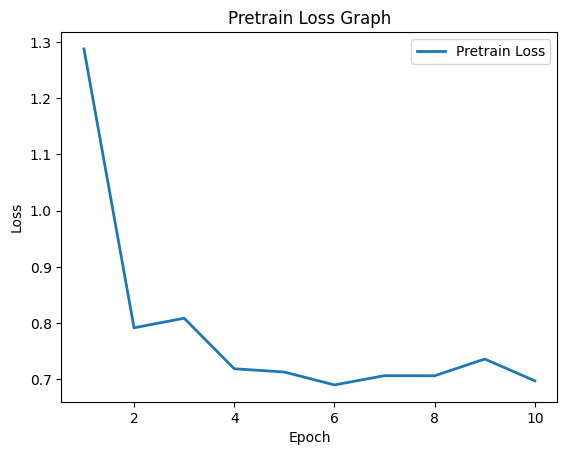

Total Training Time: 9.89 minutes


In [14]:
if __name__ == '__main__':
    configs={
        # basic setting
        'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
        'seed':0,

        # dataset hyperparameters
        'data_dir':'./data/',
        'save_dir':'./results/BYOL',
        'batch_size':256,

        # model hyperparameters
        'backbone':'resnet18',
        'hidden_dim':512,
        'projection_dim':128,
        'momentum':0.996,  

        # training hyperparameters
        'num_epochs':10,
        'optimizer':'adam',
        'lr':1e-3,
        'weight_decay':3e-4,
        'visualize':True
    }
    
    pretrained_model = main(configs)

----------------------------------

## 5. Downstream Task

### 모델 성능 평가 지표 정의

In [15]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk) 
        batch_size = target.size(0) 
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [16]:
""" 1. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)   
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        ### Train 모드 
        for epoch in range(self.epochs):
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else: ### Encoder Weight를 함께 학습
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                ### Classifier에 통과
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)
            
            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [19]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = BYOL(configs).encoder
    ### 사전학습된 Weight 불러오기
    encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_BYOL.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'save_dir':'./results/BYOL/Pretrain',
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'momentum':0.996,
               'learning_rate': 5e-3, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.3527 
Top1 Train Accuracy: 15.52 
Top1 Test Accuracy: 20.53 
Top5 Test Accuracy: 70.2 

Epoch: 2 
Loss: 2.1547 
Top1 Train Accuracy: 20.7 
Top1 Test Accuracy: 15.97 
Top5 Test Accuracy: 68.44 

Epoch: 3 
Loss: 2.0825 
Top1 Train Accuracy: 24.38 
Top1 Test Accuracy: 24.31 
Top5 Test Accuracy: 75.32 

Epoch: 4 
Loss: 2.0284 
Top1 Train Accuracy: 26.29 
Top1 Test Accuracy: 28.07 
Top5 Test Accuracy: 75.73 

Epoch: 5 
Loss: 1.9879 
Top1 Train Accuracy: 28.06 
Top1 Test Accuracy: 26.15 
Top5 Test Accuracy: 78.09 

Epoch: 6 
Loss: 1.9436 
Top1 Train Accuracy: 29.91 
Top1 Test Accuracy: 26.85 
Top5 Test Accuracy: 75.96 

Epoch: 7 
Loss: 1.9246 
Top1 Train Accuracy: 31.7 
Top1 Test Accuracy: 29.15 
Top5 Test Accuracy: 79.64 

Epoch: 8 
Loss: 1.9344 
Top1 Train Accuracy: 30.47 
Top1 Test Accuracy: 23.69 
Top5 Test Accuracy: 78.77 

Epoch: 9 
Loss: 1.897 
Top1 Train Accurac

## **실험결과 비교**

|   | Supervised Learning | SimCLR Downstream | BYOL Downstream | 
|---| ------------------- | ----------- | --------- | 
|Top 1 Test ACC| 26.77 | **39.15** | 28.71 | 
|Top 5 Test ACC| 77.13 | **89.95** | 79.58 | 